# Demo of `models.py`

In [9]:
from gcdyn import models, poisson, utils, mutators
import jax.numpy as np
from jax.config import config

config.update("jax_enable_x64", True)

## Set up truth

In [10]:
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 3.0, 1.0),
    "death_response": poisson.ConstantResponse(1.3),
    # "mutation_response": poisson.ConstantResponse(1.2),
    "mutation_response": poisson.ConstantResponse(2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

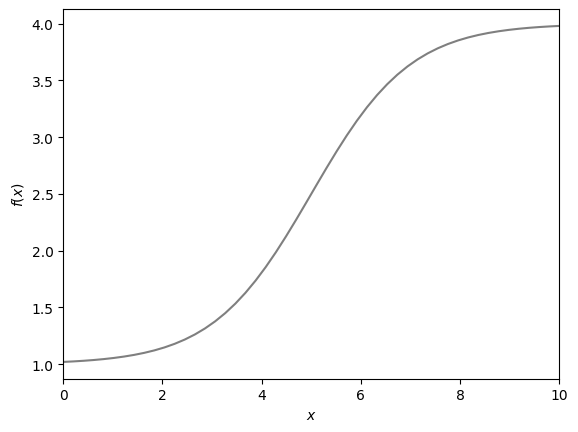

In [11]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

## Simulate some trees

In [12]:
PRESENT_TIME = 2

trees = utils.sample_trees(
    n=5,
    t=PRESENT_TIME,
    init_x=1,
    **true_parameters,
    seed=10,
    min_survivors=1,
    prune=True,
)

Sampling trees...


  0%|          | 0/5 [00:00<?, ?it/s]

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 8 times.
Success: average of 74.0 nodes per tree, over 5 trees.
Type 1 exists in 40 nodes
Type 3 exists in 37 nodes
Type 5 exists in 111 nodes
Type 7 exists in 69 nodes
Type 9 exists in 113 nodes

After pruning: average of 40.4 nodes per tree, and average of 13.4 leaves per tree, over 5 trees.
Type 1 exists in 19 nodes
Type 3 exists in 3 nodes
Type 5 exists in 52 nodes
Type 7 exists in 59 nodes
Type 9 exists in 69 nodes


## Computing likelihood

In [13]:
models.stadler_full_log_likelihood(
    trees=trees,
    **true_parameters,
    present_time=PRESENT_TIME,
    dtmax=0.01,
)

Array(-138.23099634, dtype=float64, weak_type=True)

## Maximum likelihood estimation of rate parameters

In [14]:
# Initialize with the truth

model = models.BirthDeathModel(
    log_likelihood=models.stadler_appx_log_likelihood,
    trees=trees,
    optimized_parameters={
        "birth_response": true_parameters["birth_response"],
        "death_response": true_parameters["death_response"],
    },
    fixed_parameters={
        "mutation_response": true_parameters["mutation_response"],
        "mutator": true_parameters["mutator"],
        "extant_sampling_probability": true_parameters["extant_sampling_probability"],
        "extinct_sampling_probability": true_parameters["extinct_sampling_probability"],
        "present_time": PRESENT_TIME,
    },
)

model.fit()

ScipyMinimizeInfo(fun_val=Array(133.66338242, dtype=float64, weak_type=True), success=True, status=0, iter_num=33)

In [15]:
model.parameters["birth_response"]

SigmoidResponse(xscale=7.528681085886614, xshift=4.974703374097493, yscale=2.186523657915787, yshift=0.3873370827256319)

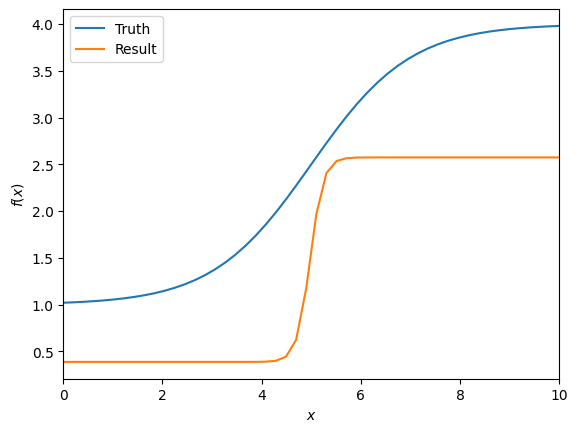

In [16]:
utils.plot_responses(
    Truth=true_parameters["birth_response"],
    Result=model.parameters["birth_response"],
    x_range=(0, 10),
)